In [3]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

import random
import logging
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [9, 2]
plt.rcParams["figure.dpi"] = 200
plt.rcParams["agg.path.chunksize"] = 100000
pd.set_option("plotting.backend", "matplotlib")
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.33 ms (started: 2023-08-04 17:44:22 -04:00)


In [4]:
from sklearn.preprocessing import MinMaxScaler
from smd.datamodule import SMDDataModule

SEQ_LEN = 12
MAX_EPOCHS = 60
N_FEATURES = 38
BATCH_SIZE = 64

datamodule = SMDDataModule(
    data_dir="data/",
    seq_len=SEQ_LEN,
    preproc_transforms=[MinMaxScaler()],
)

time: 575 µs (started: 2023-08-04 17:44:26 -04:00)


In [5]:
from torchinfo import summary
from numalogic.models.vae.variants import Conv1dVAE

datamodule.setup("fit")
for batch in datamodule.train_dataloader():
    print(batch.shape)
    break

vae = Conv1dVAE(
    seq_len=SEQ_LEN,
    n_features=N_FEATURES,
    latent_dim=6
)
summary(vae, input_size=(BATCH_SIZE, SEQ_LEN, N_FEATURES),
        col_names=["input_size", "output_size", "num_params"])

Train size: (14240, 38)
Val size: (2848, 38)
torch.Size([64, 12, 38])


/Users/abasu/opt/anaconda3/envs/numalogic-benchmarks/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Conv1dVAE                                [64, 12, 38]              --                        --
├─Encoder: 1-1                           [64, 38, 12]              [64, 6]                   --
│    └─CausalConvBlock: 2-1              [64, 38, 12]              [64, 16, 6]               --
│    │    └─CausalConv1d: 3-1            [64, 38, 12]              [64, 16, 6]               1,840
│    │    └─BatchNorm1d: 3-2             [64, 16, 6]               [64, 16, 6]               32
│    │    └─ReLU: 3-3                    [64, 16, 6]               [64, 16, 6]               --
│    └─Flatten: 2-2                      [64, 16, 6]               [64, 96]                  --
│    └─Linear: 2-3                       [64, 96]                  [64, 6]                   582
│    └─Linear: 2-4                       [64, 6]                   [64, 6]                   42
│    └─Linear: 2-5             

time: 73.5 ms (started: 2023-08-04 17:45:04 -04:00)


In [6]:
from numalogic.models.vae import VAETrainer

trainer = VAETrainer(
    accelerator="cpu",
    max_epochs=MAX_EPOCHS,
    enable_model_summary=True,
)
trainer.fit(vae, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 2.5 K 
1 | decoder | Decoder | 4.2 K 
------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Train size: (14240, 38)
Val size: (2848, 38)


INFO:numalogic.tools.callbacks:epoch=1, train_kld_loss=63.7416, train_recon_loss=1460.9590
INFO:numalogic.tools.callbacks:epoch=5, val_loss=271.1143
INFO:numalogic.tools.callbacks:epoch=5, train_kld_loss=29.0672, train_recon_loss=237.6681
INFO:numalogic.tools.callbacks:epoch=10, val_loss=212.9069
INFO:numalogic.tools.callbacks:epoch=10, train_kld_loss=24.0583, train_recon_loss=127.3503
INFO:numalogic.tools.callbacks:epoch=15, val_loss=227.4695
INFO:numalogic.tools.callbacks:epoch=15, train_kld_loss=20.7355, train_recon_loss=103.0514
INFO:numalogic.tools.callbacks:epoch=20, val_loss=262.9185
INFO:numalogic.tools.callbacks:epoch=20, train_kld_loss=18.3562, train_recon_loss=91.9451
INFO:numalogic.tools.callbacks:epoch=25, val_loss=294.6591
INFO:numalogic.tools.callbacks:epoch=25, train_kld_loss=16.3276, train_recon_loss=86.1728
INFO:numalogic.tools.callbacks:epoch=30, val_loss=344.8985
INFO:numalogic.tools.callbacks:epoch=30, train_kld_loss=15.0732, train_recon_loss=81.3782
INFO:numalogic

time: 3min (started: 2023-08-04 17:45:39 -04:00)


In [7]:
train_reconerr = trainer.predict(vae, dataloaders=datamodule.train_dataloader(), unbatch=True).numpy()
val_reconerr = trainer.predict(vae, dataloaders=datamodule.val_dataloader(), unbatch=True).numpy()
test_reconerr = trainer.predict(vae, dataloaders=datamodule.predict_dataloader(), unbatch=True).numpy()

Test size: (8543, 38)
Test size: (8543, 38)
Test size: (8543, 38)
time: 890 ms (started: 2023-08-04 17:49:31 -04:00)


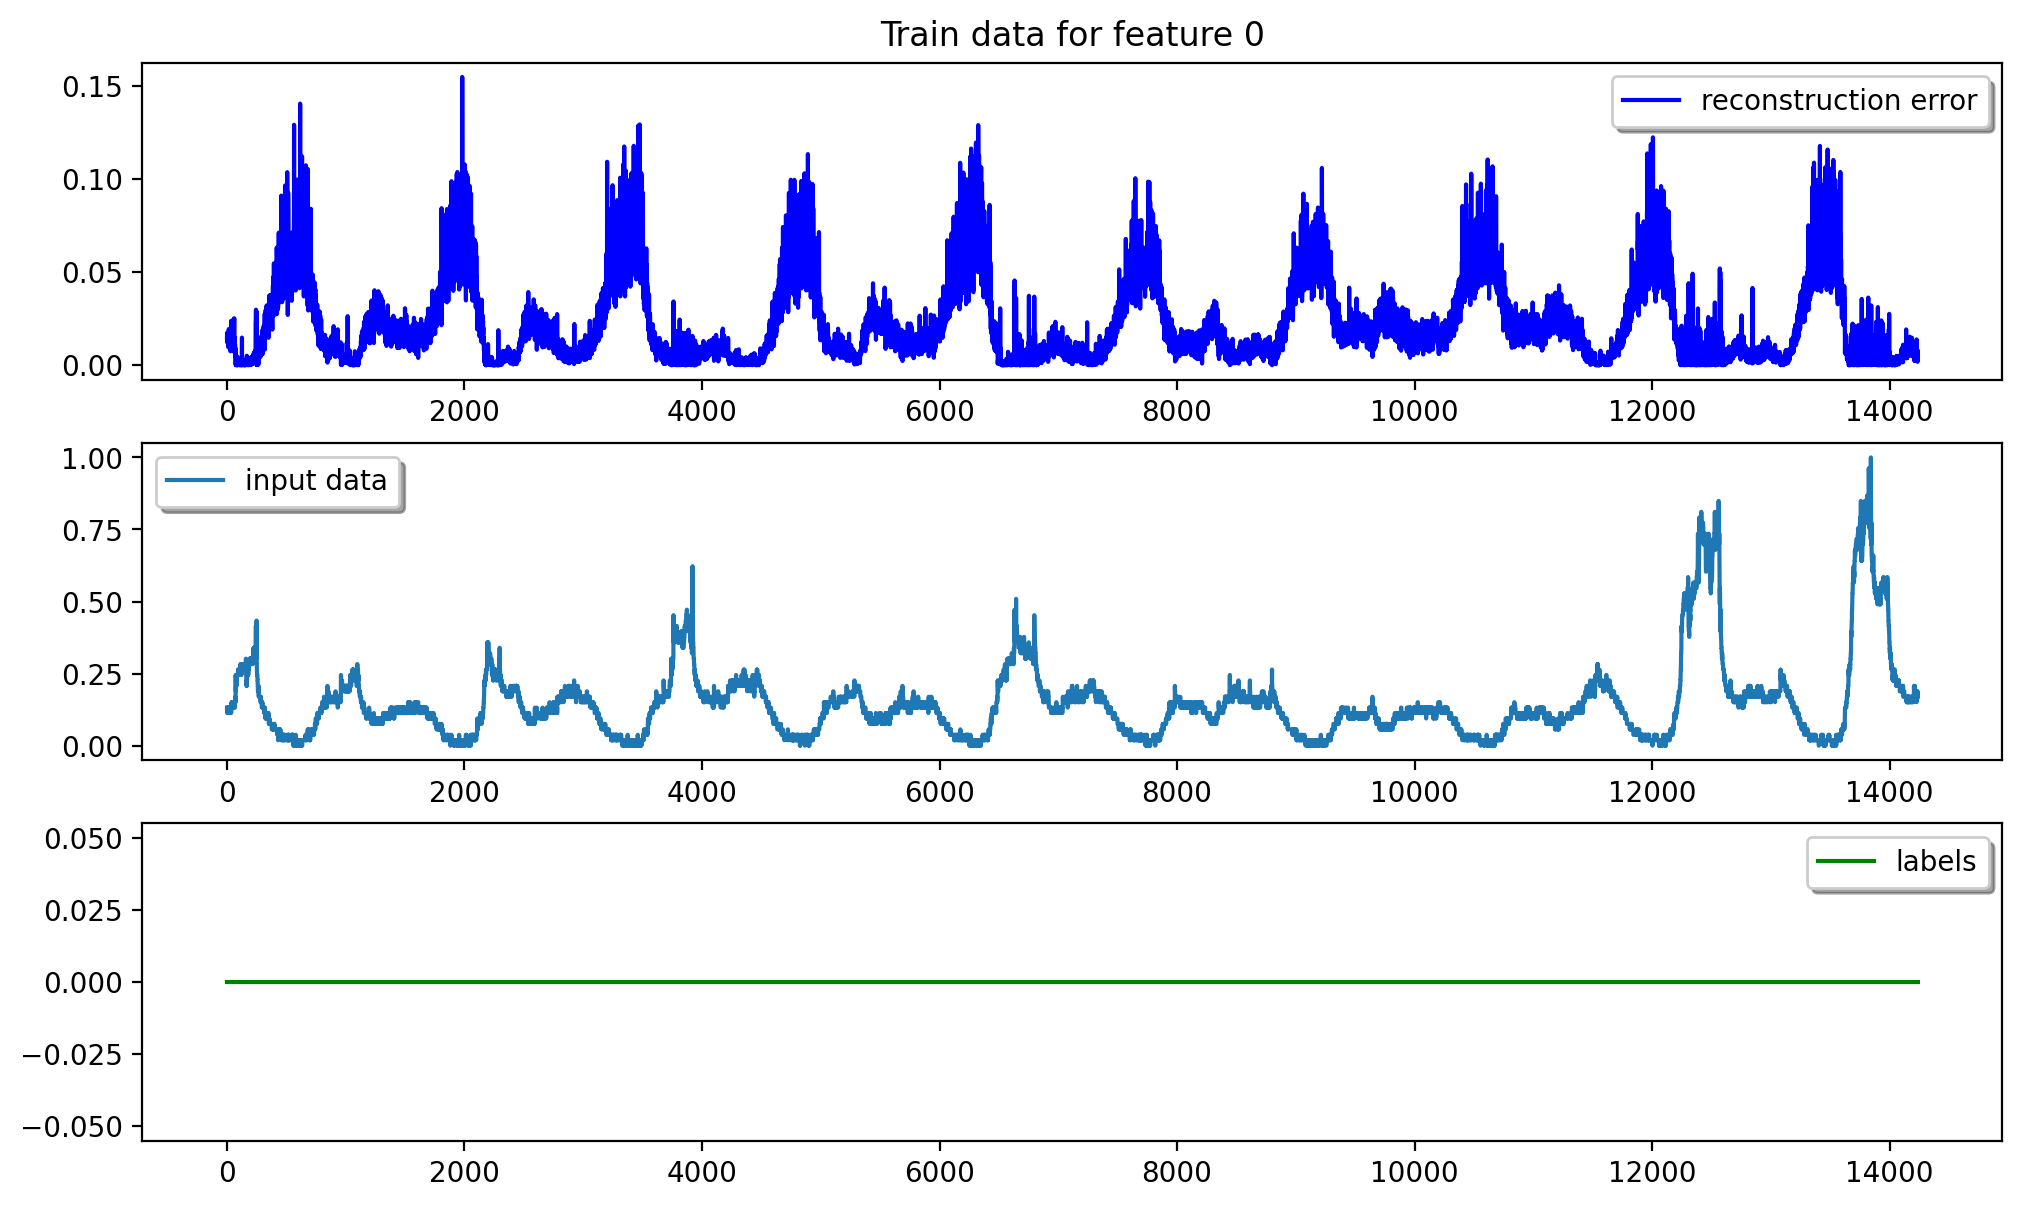

time: 587 ms (started: 2023-08-04 17:49:34 -04:00)


In [8]:
from shared.plots import plot_reconerr_comparision

feature_idx = 0
_ = plot_reconerr_comparision(
    train_reconerr,
    datamodule.train_data,
    datamodule.train_labels,
    feature_idx=feature_idx,
    title=f"Train data for feature {feature_idx}"
)

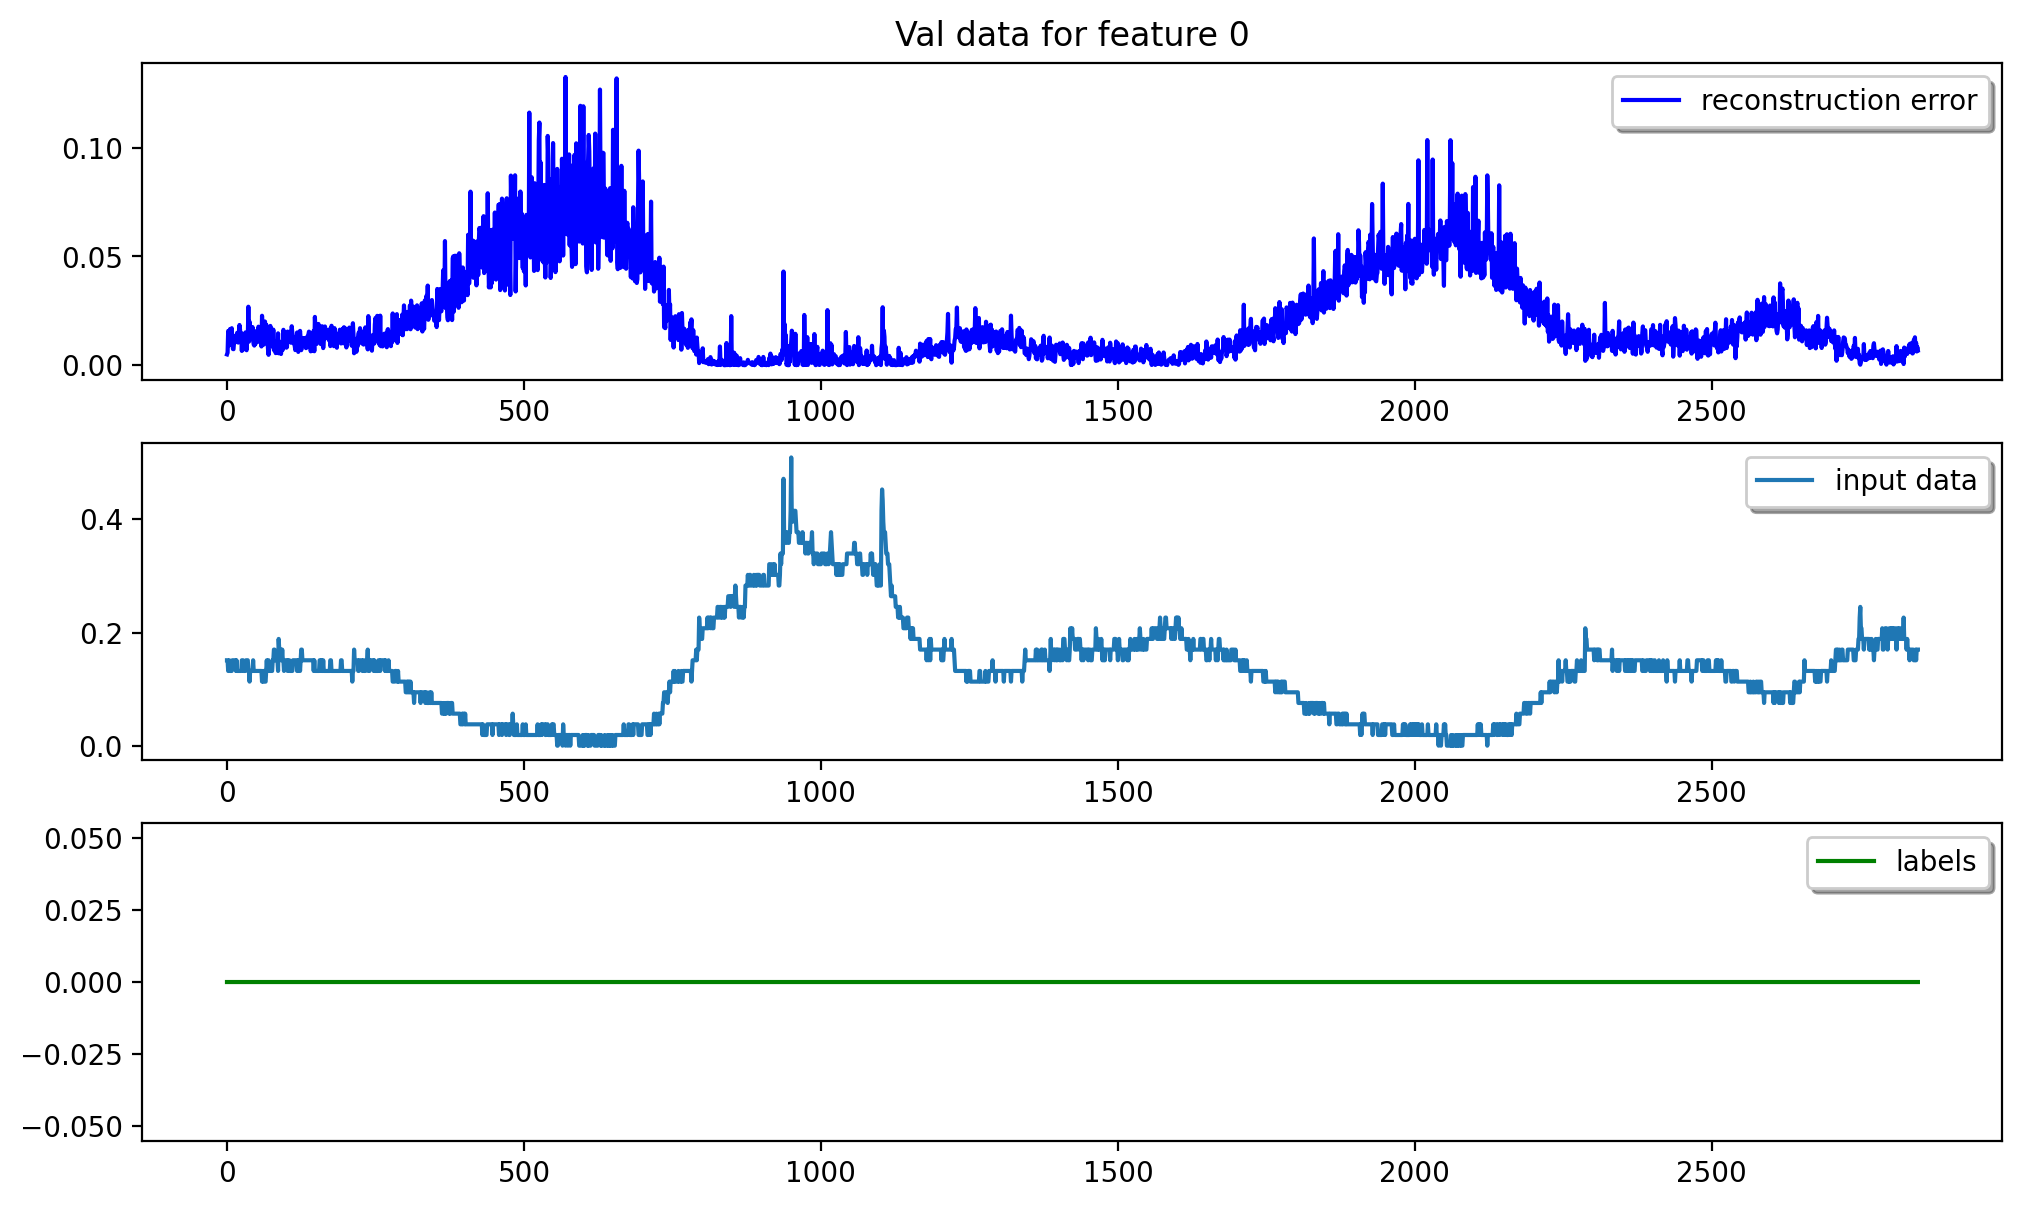

time: 328 ms (started: 2023-08-04 17:49:38 -04:00)


In [9]:
_ = plot_reconerr_comparision(
    val_reconerr,
    datamodule.val_data,
    datamodule.val_labels,
    feature_idx=feature_idx,
    title=f"Val data for feature {feature_idx}"
)

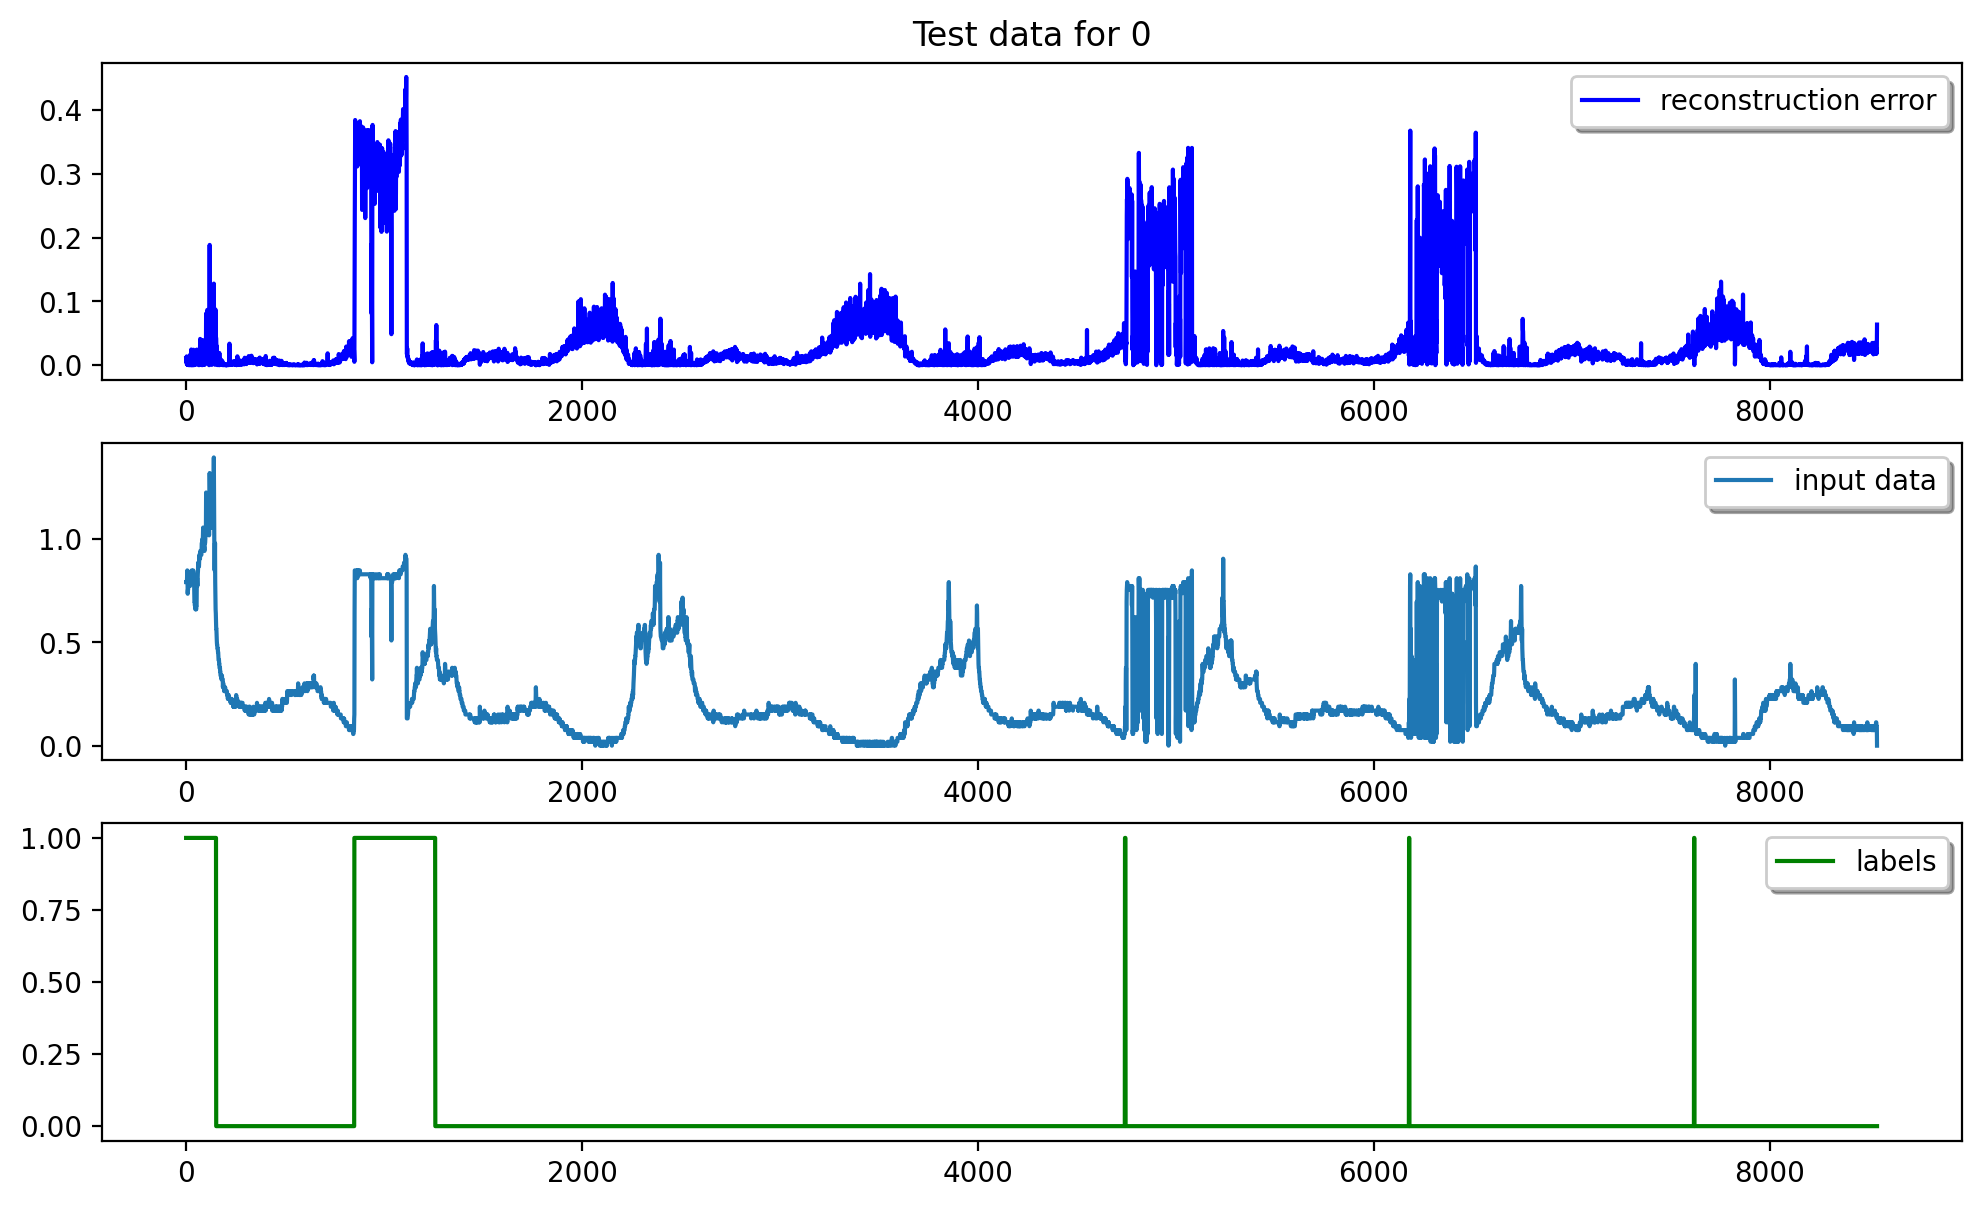

time: 436 ms (started: 2023-08-04 17:49:41 -04:00)


In [10]:
_ = plot_reconerr_comparision(
    test_reconerr,
    datamodule.test_data,
    datamodule.test_labels,
    feature_idx=feature_idx,
    title=f"Test data for {feature_idx}"
)

In [11]:
from numalogic.models.threshold import MahalanobisThreshold

clf = MahalanobisThreshold()
clf.fit(val_reconerr)
print(clf.threshold, clf.std_factor)
md_test_scores = clf.score_samples(test_reconerr)

14.063458464258527 3.162277660168379
time: 197 ms (started: 2023-08-04 17:49:45 -04:00)


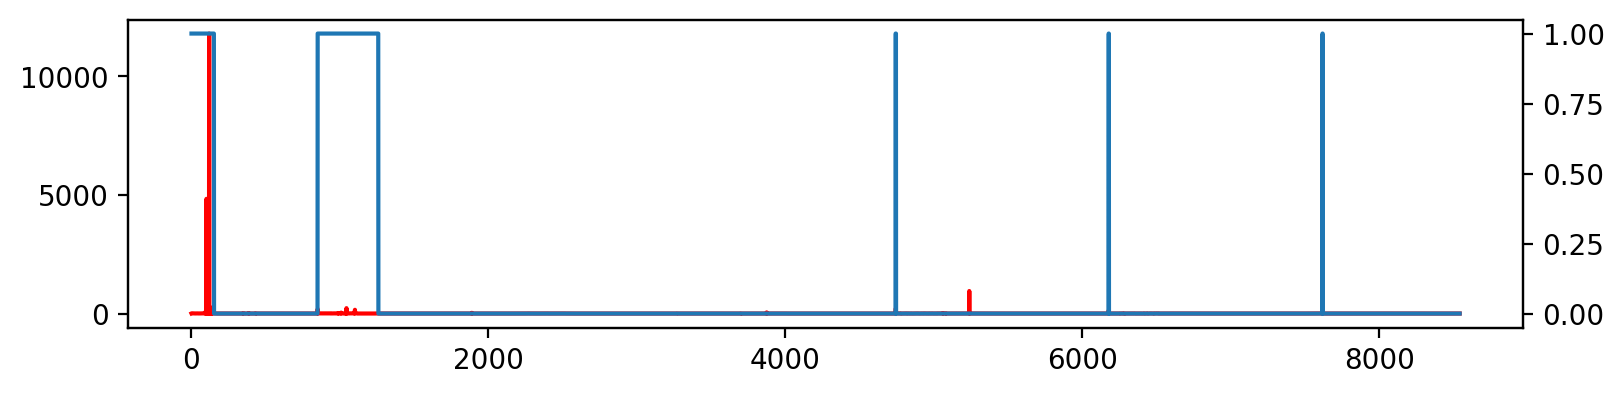

time: 116 ms (started: 2023-08-04 17:49:46 -04:00)


In [12]:
ax1 = plt.subplot()
ax1.plot(md_test_scores, color="r")
ax2 = ax1.twinx()
ax2.plot(datamodule.test_labels)

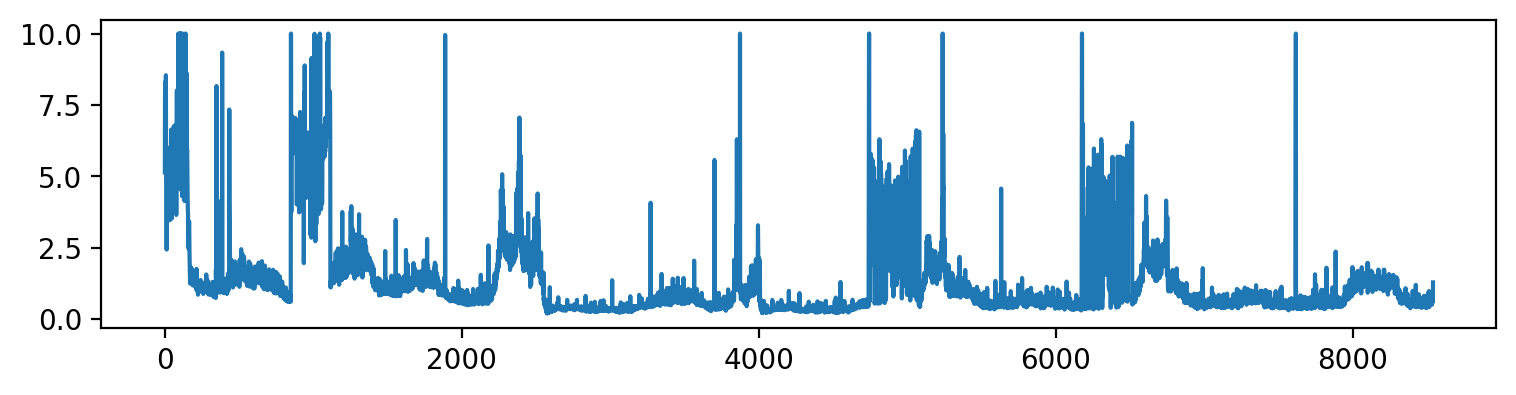

time: 115 ms (started: 2023-08-04 17:49:48 -04:00)


In [13]:
from numalogic.transforms import TanhNorm

tanh_norm = TanhNorm()
plt.plot(tanh_norm.transform(md_test_scores))

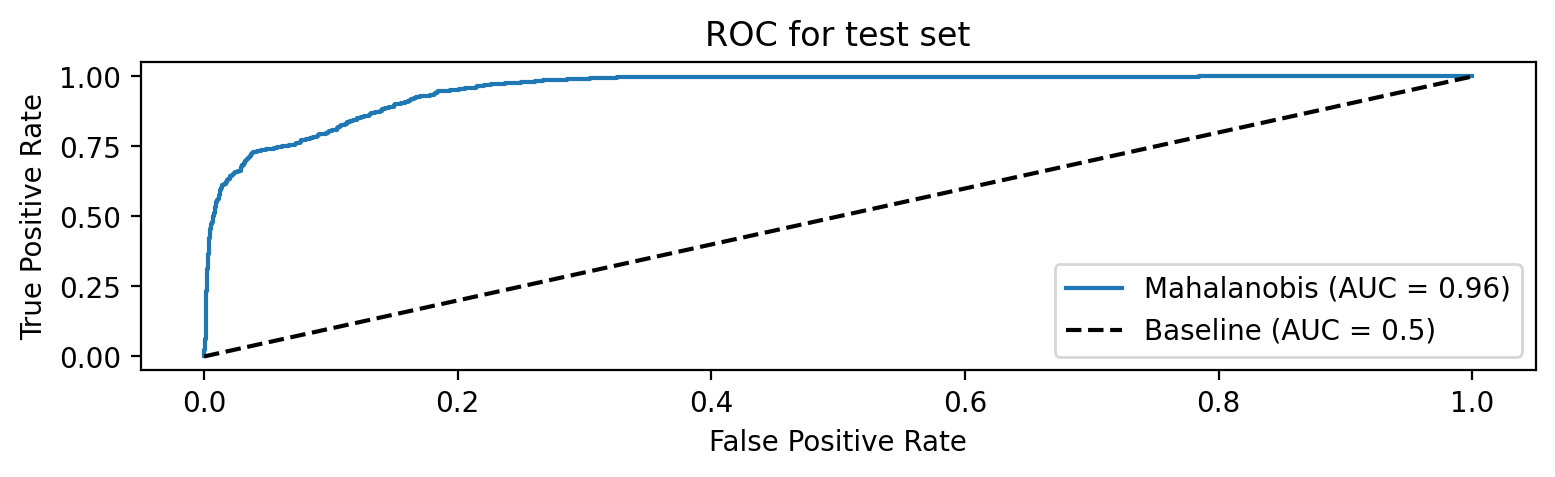

time: 142 ms (started: 2023-08-04 17:49:50 -04:00)


In [14]:
from shared.plots import plot_roc_curve

plot_roc_curve(datamodule.test_labels, md_test_scores, "Mahalanobis", title="ROC for test set")

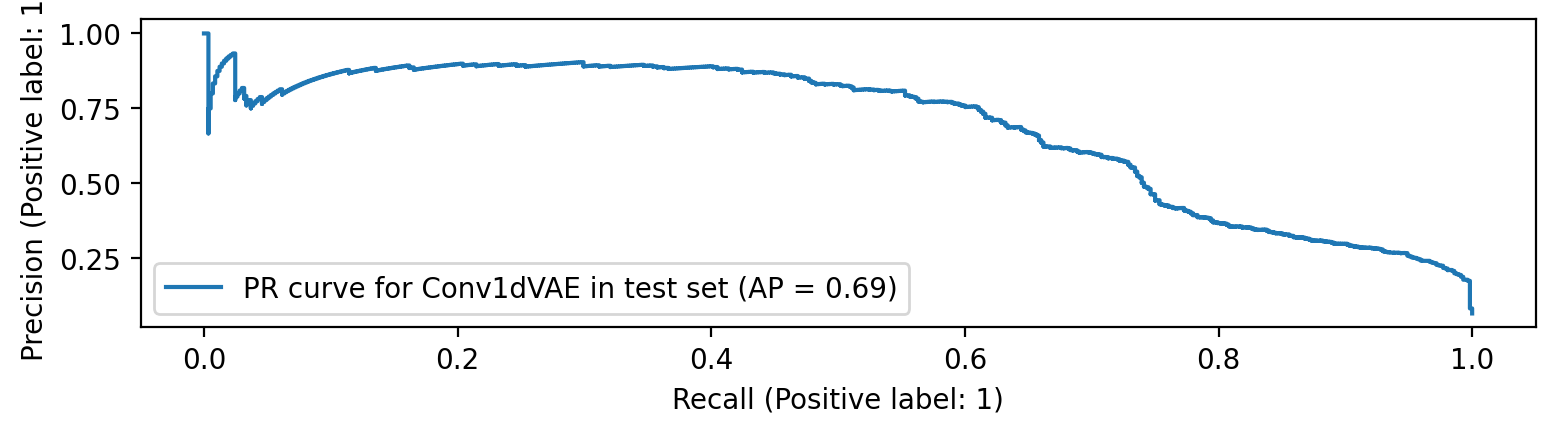

time: 116 ms (started: 2023-08-04 17:49:54 -04:00)


In [15]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(datamodule.test_labels, md_test_scores, name="PR curve for Conv1dVAE in test set")